# PANN - Prompt-Aware Neural Network Demo

Treinamento rápido (2 épocas) do modelo PANN que separa:
- **EQ-net**: Essay Quality (features invariantes ao prompt)
- **PA-net**: Prompt Adherence (features específicas do prompt)
- **ESP**: Essay Score Predictor (combina os dois)

**Configuração**: Treinar em prompts [1,3,4,5,6,7,8] → Testar em prompt 2

## Importar bibliotecas

In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import numpy as np
from tqdm import tqdm

from src.data.dataset import ASAPDataset
from src.data.pann_dataset import PANNDataset
from src.models.pann.model import PANN, PANNConfig
from src.evaluation.metrics import compute_qwk, compute_correlations

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Carregar e preparar dados

In [2]:
data_path = '../data/raw/training_set_rel3.tsv'
dataset_loader = ASAPDataset(data_path)
df = dataset_loader.load_data()

test_prompt = 2
train_prompts = [1, 3, 4, 5, 6, 7, 8]

train_df = df[df['essay_set'].isin(train_prompts)].copy()
test_df = df[df['essay_set'] == test_prompt].copy()

print(f"Train: {len(train_df)} essays")
print(f"Test: {len(test_df)} essays")

Loading ASAP dataset from ../data/raw/training_set_rel3.tsv
Loaded 12976 essays across 8 prompts
Train: 11176 essays
Test: 1800 essays


In [3]:
train_df['normalized_score'] = train_df.apply(
    lambda row: dataset_loader.normalize_score(row['domain1_score'], row['essay_set']),
    axis=1
)

test_df['normalized_score'] = test_df.apply(
    lambda row: dataset_loader.normalize_score(row['domain1_score'], row['essay_set']),
    axis=1
)

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nScore normalization example (Prompt {test_prompt}):")
print(f"  Original range: {dataset_loader.SCORE_RANGES[test_prompt]}")
print(f"  Normalized range: [0.0, 1.0]")

Train samples: 11176
Test samples: 1800

Score normalization example (Prompt 2):
  Original range: (1, 6)
  Normalized range: [0.0, 1.0]


## Carregar prompts textuais

In [4]:
import json

with open('../data/raw/prompt_texts.json', 'r') as f:
    prompt_texts = json.load(f)

print(f"Loaded {len(prompt_texts)} prompt texts")
print(f"\nExample - Prompt 2:\n{prompt_texts['2'][:200]}...")

Loaded 8 prompt texts

Example - Prompt 2:
Write about whether or not you believe censorship of books and other materials is justified. Use examples from your reading or experience to support your position....


## Criar datasets PANN

In [5]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

train_dataset = PANNDataset(
dataframe=train_df,
tokenizer=tokenizer,
max_essay_length=512,
max_prompt_length=128,
prompt_texts=prompt_texts
)

test_dataset = PANNDataset(
dataframe=test_df,
tokenizer=tokenizer,
max_essay_length=512,
max_prompt_length=128,
prompt_texts=prompt_texts
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 699
Test batches: 113


## Inicializar modelo PANN

In [6]:
config = PANNConfig(
    bert_model='bert-base-uncased',
    num_kernels=8,
    kernel_width=0.1,
    fc_layers=2,
    fc_hidden_size=256,
    dropout=0.1
)

model = PANN(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

PANN initialized with 219,824,897 parameters
Total parameters: 219,824,905


## Verificar arquitetura PANN

In [7]:
batch = next(iter(train_loader))

batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}

with torch.no_grad():
    outputs = model(
        batch['input_ids'],
        batch['attention_mask'],
        batch['prompt_input_ids'],
        batch['prompt_attention_mask']
    )

print(f"Output keys: {outputs.keys()}")
print(f"Predictions shape: {outputs['predictions'].shape}")
print(f"\nModel components:")
print(f"  - EQ-net: Extracts quality features (v_i) [batch, 768]")
print(f"  - PA-net: Extracts adherence features (u_i) [batch, 24]")
print(f"  - ESP: Combines features → score [batch, 1]")

Output keys: dict_keys(['predictions', 'eq_features', 'pa_features'])
Predictions shape: torch.Size([16])

Model components:
  - EQ-net: Extracts quality features (v_i) [batch, 768]
  - PA-net: Extracts adherence features (u_i) [batch, 24]
  - ESP: Combines features → score [batch, 1]


## Função de treinamento por época

In [8]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    pbar = tqdm(loader, desc='Training')
    for batch in pbar:
        essay_ids = batch['input_ids'].to(device)
        essay_mask = batch['attention_mask'].to(device)
        prompt_ids = batch['prompt_input_ids'].to(device)
        prompt_mask = batch['prompt_attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(essay_ids, essay_mask, prompt_ids, prompt_mask)

        loss = criterion(outputs['predictions'], labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(loader)

## Função de avaliação

In [9]:
def evaluate(model, loader, device):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            essay_ids = batch['input_ids'].to(device)
            essay_mask = batch['attention_mask'].to(device)
            prompt_ids = batch['prompt_input_ids'].to(device)
            prompt_mask = batch['prompt_attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(essay_ids, essay_mask, prompt_ids, prompt_mask)

            predictions.extend(outputs['predictions'].cpu().numpy().tolist())
            targets.extend(labels.cpu().numpy().tolist())

    return np.array(predictions), np.array(targets)

## Treinamento (2 épocas)

In [10]:
num_epochs = 2
history = {'train_loss': [], 'test_qwk': []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 70)
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    history['train_loss'].append(train_loss)
    
    preds, targets = evaluate(model, test_loader, device)
    
    min_score, max_score = dataset_loader.SCORE_RANGES[test_prompt]
    preds_denorm = preds * (max_score - min_score) + min_score
    targets_denorm = targets * (max_score - min_score) + min_score
    preds_denorm = np.round(np.clip(preds_denorm, min_score, max_score))
    
    qwk = compute_qwk(targets_denorm, preds_denorm, min_score, max_score)
    history['test_qwk'].append(qwk)
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test QWK: {qwk:.4f}") 

Evaluating: 100%|██████████| 113/113 [02:06<00:00,  1.12s/it]


Train Loss: 0.0378
Test QWK: 0.3064

Epoch 2/2
----------------------------------------------------------------------


Evaluating: 100%|██████████| 113/113 [02:13<00:00,  1.18s/it]

Train Loss: 0.0227
Test QWK: 0.5050


## Avaliação final completa

In [11]:
preds, targets = evaluate(model, test_loader, device)

min_score, max_score = dataset_loader.SCORE_RANGES[test_prompt]
preds_denorm = preds * (max_score - min_score) + min_score
targets_denorm = targets * (max_score - min_score) + min_score
preds_denorm = np.round(np.clip(preds_denorm, min_score, max_score))

qwk = compute_qwk(targets_denorm, preds_denorm, min_score, max_score)
correlations = compute_correlations(targets_denorm, preds_denorm)

print("\n" + "="*70)
print("Final Test Results - PANN")
print("="*70)
print(f"QWK: {qwk:.4f}")
print(f"Pearson: {correlations['pearson']:.4f}")
print(f"Spearman: {correlations['spearman']:.4f}")
print("="*70)

Evaluating: 100%|██████████| 113/113 [02:02<00:00,  1.08s/it]


Final Test Results - PANN
QWK: 0.5050
Pearson: 0.6676
Spearman: 0.6288


## Extrair features EQ e PA

In [14]:
model.eval()
batch = next(iter(test_loader))

batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}

with torch.no_grad():
    # Usar os nomes corretos: 'input_ids' e 'attention_mask'
    v_i = model.eq_net(
        batch['input_ids'],
        batch['attention_mask']
    )
    u_i = model.pa_net(
        batch['prompt_input_ids'],
        batch['prompt_attention_mask'],
        batch['input_ids'],
        batch['attention_mask']
    )

print(f"EQ features (v_i) shape: {v_i.shape}")
print(f"PA features (u_i) shape: {u_i.shape}")
print(f"\nEQ-net captures: Quality (grammar, coherence, structure)")
print(f"PA-net captures: Adherence (relevance to prompt, coverage)")

EQ features (v_i) shape: torch.Size([16, 768])
PA features (u_i) shape: torch.Size([16, 24])

EQ-net captures: Quality (grammar, coherence, structure)
PA-net captures: Adherence (relevance to prompt, coverage)


## Visualizar curva de aprendizado

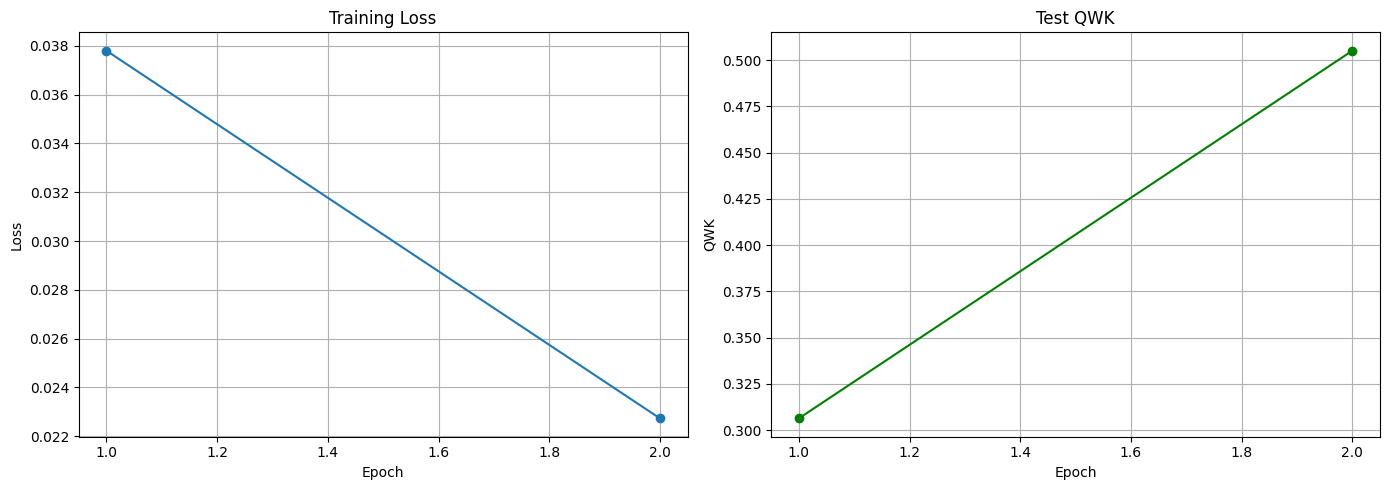

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, num_epochs + 1), history['train_loss'], marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True)

axes[1].plot(range(1, num_epochs + 1), history['test_qwk'], marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('QWK')
axes[1].set_title('Test QWK')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Distribuição de predições vs targets

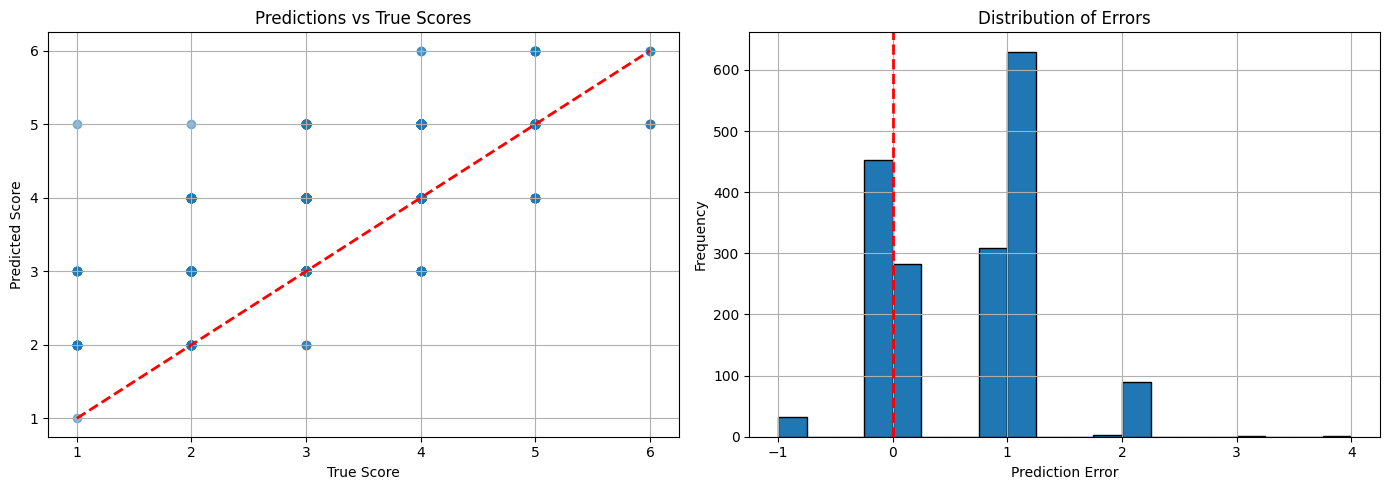

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(targets_denorm, preds_denorm, alpha=0.5)
axes[0].plot([min_score, max_score], [min_score, max_score], 'r--', lw=2)
axes[0].set_xlabel('True Score')
axes[0].set_ylabel('Predicted Score')
axes[0].set_title('Predictions vs True Scores')
axes[0].grid(True)

errors = preds_denorm - targets_denorm
axes[1].hist(errors, bins=20, edgecolor='black')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Errors')
axes[1].axvline(0, color='r', linestyle='--', lw=2)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Salvar modelo

In [17]:
from pathlib import Path

output_dir = Path('../checkpoints/pann_demo')
output_dir.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), output_dir / 'model.pt')

results = {
    'test_prompt': test_prompt,
    'train_prompts': train_prompts,
    'epochs': num_epochs,
    'qwk': float(qwk),
    'pearson': float(correlations['pearson']),
    'spearman': float(correlations['spearman'])
}

with open(output_dir / 'results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"Model saved to {output_dir}")

Model saved to ../checkpoints/pann_demo
